<a href="https://colab.research.google.com/github/juanandres-montero/macroeconometria/blob/main/Laboratorio_09_Cambio_Estructural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<link rel="stylesheet" type="text/css"
    href="https://cdn.rawgit.com/dreampulse/computer-modern-web-font/master/fonts.css">
<style>
body {
  font-family: "Computer Modern Sans", sans-serif;
}
h1, h3 {
  font-weight: bold;
}
</style>

<center>
  <img src="https://github.com/juanandres-montero/microeconometria/blob/main/logo%20EEC%20grande.png?raw=1" width="396" height="161">
  <h1></h1>
  <h1 style="text-align: center;">EC-4301 MACROECONOMETRÍA</h1>
  <h2 style="text-align: center;">Asist. Juan Andrés Montero Zúñiga</h2>
  <br>
  <h3> Laboratorio 09:</h3>
  <div style="font-size:250%;color:white; background-color: #0064b0;">Cambio Estructural</div>
</center>
<br><br>

<i>
    Creado: 2024-Jun
</i>

<hr>

# Prueba de Chow

Limpieza y carga de datos:

In [ ]:
!wget https://github.com/juanandres-montero/macroeconometria/raw/main/oil_test.xlsx
import pandas as pd
df = pd.read_excel("/content/oil_test.xlsx", sheet_name="Hoja3")

--2024-06-30 05:21:57--  https://github.com/juanandres-montero/macroeconometria/raw/main/oil_test.xlsx
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/juanandres-montero/macroeconometria/main/oil_test.xlsx [following]
--2024-06-30 05:21:58--  https://raw.githubusercontent.com/juanandres-montero/macroeconometria/main/oil_test.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705 (19K) [application/octet-stream]
Saving to: ‘oil_test.xlsx’

oil_test.xlsx       100%[===================>]  19.24K  --.-KB/s    in 0.004s  

2024-06-30 05:21:58 (4.21 MB/s) - ‘oil_test.xlsx’ saved [19705/19705]



Conversión de variables a formato numérico:

In [ ]:
df = df.apply(pd.to_numeric, errors='coerce')

Generación de nuevas variables:

In [ ]:
df['Gas_per_capita'] = df['GasExp'] / df['Pop'] / df['Gasp']
df['t'] = df['Year'] - 1952
df['lngpc'] = np.log(df['Gas_per_capita'])
df['lnincome'] = np.log(df['Income'])
df['lnpg'] = np.log(df['Gasp'])
df['lnpnc'] = np.log(df['PNC'])
df['lnpuc'] = np.log(df['PUC'])
df['cons_percapita_millon'] = df['Gas_per_capita'] * 1_000_000

Gráfico de dispersión del consumo per cápita de gasolina:

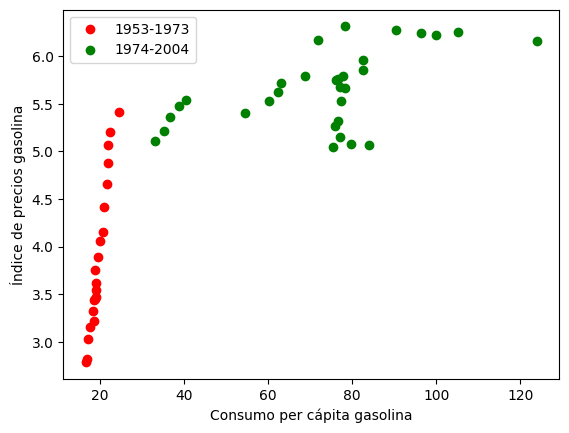

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df[df['Year'] <= 1973]['Gasp'], df[df['Year'] <= 1973]['cons_percapita_millon'], color='red', label='1953-1973')
plt.scatter(df[df['Year'] > 1973]['Gasp'], df[df['Year'] > 1973]['cons_percapita_millon'], color='green', label='1974-2004')
plt.legend()
plt.xlabel('Consumo per cápita gasolina')
plt.ylabel('Índice de precios gasolina')
plt.show()

Regresión para diferentes períodos:

In [ ]:
import statsmodels.api as sm

X = df[['lnincome', 'lnpg', 'lnpnc', 'lnpuc', 't']]
X = sm.add_constant(X)
y = df['lngpc']

model_full = sm.OLS(y, X).fit()
S = model_full.ssr  # Suma de residuos al cuadrado (SSR)
print(model_full.summary())
print(f"S = {S}")

model_pre1974 = sm.OLS(y[df['Year'] < 1974], X[df['Year'] < 1974]).fit()
S_pre1974 = model_pre1974.ssr  # SSR
print("\nRegresión 1953-1973:")
print(model_pre1974.summary())
print(f"S_2 (1953-1973) = {S_pre1974}")

model_post1973 = sm.OLS(y[df['Year'] > 1973], X[df['Year'] > 1973]).fit()
S_post1973 = model_post1973.ssr  # SSR
print("\nRegresión 1974-2004:")
print(model_post1973.summary())
print(f"S_2 (1974-2004) = {S_post1973}")

                            OLS Regression Results                            
Dep. Variable:                  lngpc   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     253.2
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           2.91e-32
Time:                        05:23:25   Log-Likelihood:                 88.301
No. Observations:                  52   AIC:                            -164.6
Df Residuals:                      46   BIC:                            -152.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.6787      2.000    -13.337      0.0

Cálculo y decisión estadística:

In [ ]:
# Cálculo del estadístico de Chow
from scipy.stats import f
n1 = len(df[df['Year'] < 1974])
n2 = len(df[df['Year'] > 1973])
k = 6  # Número de coeficientes
S2 = S_pre1974 + S_post1973
T = len(df)

F_statistic = ((S2 - S) / k) / (S / (T - 2 * k))
critical_value = f.ppf(0.99, k, T - (2 * k))

print(f"\nEstadístico F: {F_statistic}")
print(f"Valor crítico F(99%, {k}, {T - 2 * k}): {critical_value}")

if abs(F_statistic) > abs(critical_value):
    print("Rechazamos la hipótesis nula. Hay un cambio estructural.")
else:
    print("No rechazamos la hipótesis nula. No hay un cambio estructural.")


Estadístico F: -6.068587172564431
Valor crítico F(99%, 6, 40): 3.2910123892986864
Rechazamos la hipótesis nula. Hay un cambio estructural.


# Prueba de Andrews

Limpieza y carga de datos:

In [ ]:
!wget https://github.com/juanandres-montero/macroeconometria/raw/main/Infinteranual.xlsx
df_inflation = pd.read_excel("/content/Infinteranual.xlsx", sheet_name="Hoja1")

--2024-06-30 05:38:39--  https://github.com/juanandres-montero/macroeconometria/raw/main/Infinteranual.xlsx
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/juanandres-montero/macroeconometria/main/Infinteranual.xlsx [following]
--2024-06-30 05:38:39--  https://raw.githubusercontent.com/juanandres-montero/macroeconometria/main/Infinteranual.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16431 (16K) [application/octet-stream]
Saving to: ‘Infinteranual.xlsx’

Infinteranual.xlsx  100%[===================>]  16.05K  --.-KB/s    in 0.003s  

2024-06-30 05:38:40 (4.64 MB/s) - ‘Infinteranual.xls

Generación de la variable de tiempo:

In [ ]:
df_inflation['Mes'] = df_inflation['Mes'].str.replace('m', '-') # Replace 'm' with '-' to create 'YYYY-MM' format
df_inflation['month'] = pd.to_datetime(df_inflation['Mes'], format='%Y-%m')

# Set 'month' as index and filter data
df_inflation = df_inflation.set_index('month')
df_inflation = df_inflation[df_inflation.index < '2004-01-01']

Visualización de la serie temporal y la prueba de Andrews:

In [ ]:
!pip install ruptures -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.1 MB/s eta 0:00:00


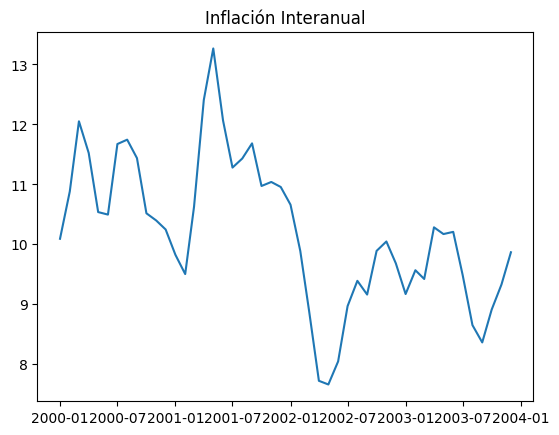

                            OLS Regression Results                            
Dep. Variable:               Infinter   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     113.0
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           7.45e-14
Time:                        05:41:55   Log-Likelihood:                -46.906
No. Observations:                  47   AIC:                             97.81
Df Residuals:                      45   BIC:                             101.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5660      0.819      1.911      0.0

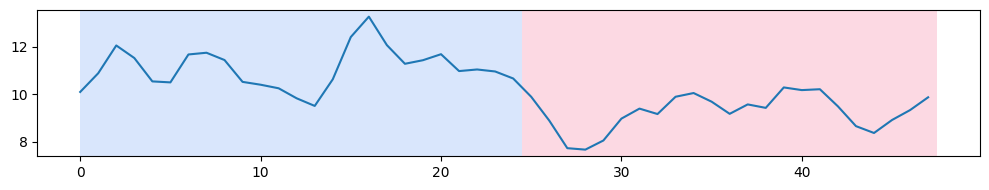

In [ ]:
plt.plot(df_inflation['Infinter'])
plt.title('Inflación Interanual')
plt.show()

model_inflation = sm.OLS(df_inflation['Infinter'][1:], sm.add_constant(df_inflation['Infinter'].shift(1).dropna())).fit()
#Slice the original 'Infinter' column to start from the second element to match the lagged variable's index after dropping NaN
print(model_inflation.summary())

# Para la prueba de Andrews, se puede usar una biblioteca específica como `ruptures` para detectar puntos de cambio
import ruptures as rpt

signal = df_inflation['Infinter'].values
algo = rpt.Binseg(model="l2").fit(signal)
result = algo.predict(n_bkps=1)

rpt.display(signal, result)
plt.show()

# Raíz unitaria con cambio estructural

Simulación de datos:

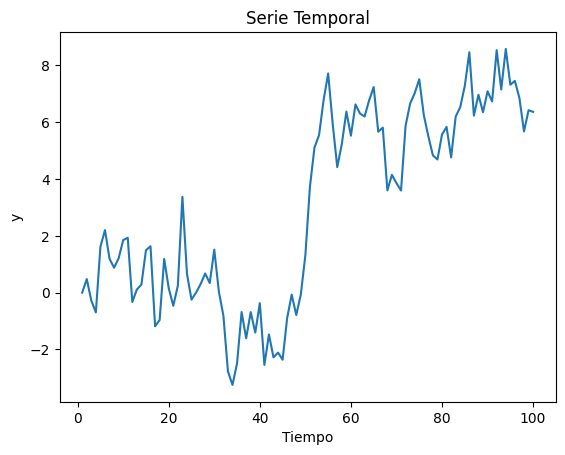

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Simulación de datos
np.random.seed(12345)
t = np.arange(1, 101)
D = np.where(t > 50, 3, 0)
epsilon = np.random.normal(0, 1, 100)
y = np.zeros(100)
for i in range(1, 100):
    y[i] = 0.5 * y[i - 1] + epsilon[i] + D[i]

df = pd.DataFrame({'t': t, 'y': y})

# Gráfico de la serie temporal
plt.plot(df['t'], df['y'])
plt.xlabel('Tiempo')
plt.ylabel('y')
plt.title('Serie Temporal')
plt.show()


Prueba de raíz unitaria (Dickey-Fuller):

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['y'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}: {value}')

ADF Statistic: -1.6979139687851108
p-value: 0.4321875821532407
Critical Values:
   1%: -3.498198082189098
Critical Values:
   5%: -2.891208211860468
Critical Values:
   10%: -2.5825959973472097


Prueba de Perron (1989):

In [ ]:
# Generación de variables adicionales
df['D_P'] = np.where(df['t'] == 51, 1, 0)
df['D_L'] = np.where(df['t'] > 50, 1, 0)

# Regresión
X = df[['y', 't', 'D_P', 'D_L']].shift(1).dropna()
y = df['y'][1:]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# Cálculo del estadístico t
alpha_1 = model.params[1]
std_error = model.bse[1]
t_statistic = (alpha_1 - 1) / std_error
print(f'Estadístico t: {t_statistic}')


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     215.2
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           2.07e-46
Time:                        05:56:30   Log-Likelihood:                -146.86
No. Observations:                  99   AIC:                             303.7
Df Residuals:                      94   BIC:                             316.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0420      0.253      0.166      0.8

# Prueba CUSUM de inestabilidad de parámetros

Simulación de datos:

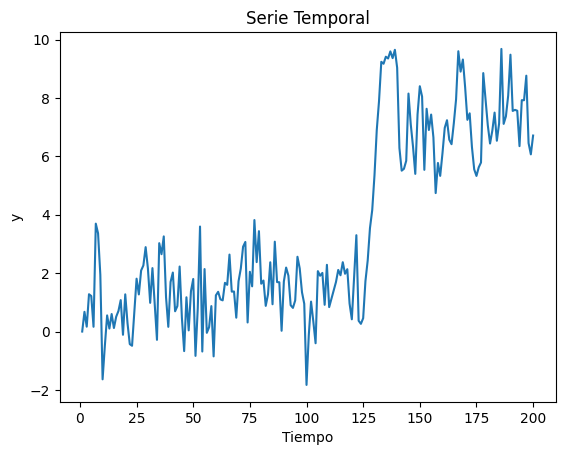

In [ ]:
# Simulación de datos
np.random.seed(2023)
t = np.arange(1, 201)
y = np.zeros(200)
epsilon = np.random.normal(0, 1, 200)
for i in range(1, 200):
    if i < 125:
        y[i] = 1 + 0.25 * y[i - 1] + epsilon[i]
    else:
        y[i] = 2.5 + 0.65 * y[i - 1] + epsilon[i]

df = pd.DataFrame({'t': t, 'y': y})

# Gráfico de la serie temporal
plt.plot(df['t'], df['y'])
plt.xlabel('Tiempo')
plt.ylabel('y')
plt.title('Serie Temporal')
plt.show()

Estimación de un AR(1) y prueba CUSUM:

In [ ]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid

# Estimación de un AR(1)
X = df[['y']].shift(1).dropna()
y = df['y'][1:]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# Prueba CUSUM
cusum_test = breaks_cusumolsresid(model.resid)
print('Estadístico CUSUM:', cusum_test[0])
print('Valor p:', cusum_test[1])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1002.
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           3.32e-79
Time:                        05:57:16   Log-Likelihood:                -328.77
No. Observations:                 199   AIC:                             661.5
Df Residuals:                     197   BIC:                             668.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3295      0.134      2.461      0.0

In [ ]:
import matplotlib.pyplot as plt

#create scatterplot
plt.plot(df.x, df.y, 'o')

AttributeError: 'DataFrame' object has no attribute 'x'

In [ ]:
!pip install scikit-learn -q
!pip install chowtest --upgrade -q

In [ ]:
from chow_test import chowtest

chowtest(y=df[['y']], X=df[['x']],
         last_index_in_model_1=15,
         first_index_in_model_2=16,
         significance_level=.05)

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

#@markdown ### Obtener datos del precio de la plata para Costa Rica
url = "https://www.cpcalc.com/cpc/api/currency/historical.php?from=XAG&to=CRC"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df[0])
    df.sort_values(by='date', inplace=True)
    df1 = df
    fecha_inicio = '2007-05-17'
    fecha_fin = pd.Timestamp.today().normalize()
    fechas_diarias = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
    df1.index = fechas_diarias[:len(df1)]
    df2 = df1[[1]]
    df2 = df2.rename(columns={1: 'Precio'})
    df2 = df2['2016-01-01':'2021-10-31']
    nuevo_indice = pd.date_range(start='2016-08-20', periods=len(df2), freq='D')
    df2.index = nuevo_indice


else:
    print(f"Error al obtener los datos. Código de respuesta: {response.status_code}")
df2.head()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df2['Precio'], linestyle='-', color='b', label='Precio de la plata (CRC/Onza)')
plt.title('Gráfico de precios de la plata (Costa Rican colón/Once) 2016-2022')
plt.xlabel('Fecha')
plt.ylabel('Precio (CRC)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# prompt: obten los datos del precio para los primeros 2 meses de 2020 en df2

import pandas as pd
import requests
import matplotlib.pyplot as plt

# ... (preceding code)

# Filter the data for the first two months of 2020
df_2020_02 = df2['2020-02-01':'2020-03-29']

# Display the filtered data
print(df_2020_02)


<a href="https://colab.research.google.com/github/juanandres-montero/macroeconometria/blob/main/Laboratorio_10_VAR.ipynb">Siguiente laboratorio>>></a>